In [1]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.modeling.models import Models, PowerLawSpectralModel, SkyModel

/homes/wang/swong/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data

not sure if there's a way to work around the obs_ids list - this is needed later but it's kinda annoying

In [3]:
datastore = DataStore.from_dir("/raid/romulus/swong/LIV/bllac")
observations = datastore.get_observations(required_irf="point-like")

obs_ids = [62672,62673,62674,62675,62676,62677]

print(observations)

Observations
Number of observations: 6
Observation

	obs id            : 83016 
 	tstart            : 57666.16
	tstop             : 57666.18
	duration          : 1801.00 s
	pointing (icrs)   : 330.7 deg, 41.8 deg

	deadtime fraction : 15.4%
Observation

	obs id            : 83017 
 	tstart            : 57666.19
	tstop             : 57666.21
	duration          : 1801.00 s
	pointing (icrs)   : 331.4 deg, 42.3 deg

	deadtime fraction : 14.5%
Observation

	obs id            : 83018 
 	tstart            : 57666.21
	tstop             : 57666.23
	duration          : 1801.00 s
	pointing (icrs)   : 330.0 deg, 42.3 deg

	deadtime fraction : 14.7%
Observation

	obs id            : 83019 
 	tstart            : 57666.23
	tstop             : 57666.25
	duration          : 1801.00 s
	pointing (icrs)   : 330.7 deg, 42.8 deg

	deadtime fraction : 14.4%
Observation

	obs id            : 83020 
 	tstart            : 57666.25
	tstop             : 57666.27
	duration          : 1801.00 s
	pointing (icrs)   :

# Source Details

In [4]:
target_position = SkyCoord(330.6804167 * u.deg, 42.2777778* u.deg, frame="icrs")
on_region_radius = Angle("0.08944272 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [5]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 30, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 30, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

# Make background region and mask

In [6]:
datasets = Datasets()
for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: Runti

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 62672
  Instrument : VERITAS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 62673
  Instrument : VERITAS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 62674
  Instrument : VERITAS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 62675
  Instrument : VERITAS
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 62676
  Instrument : VERITAS
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 62677
  Instrument : VERITAS
  Models     : 




/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)


In [7]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,261,242.6875,27.355177253533423,18.3125,32.588235294117645,32.588235294117645,nan,4801136.5,181925728.0,1523.3331217806794,1801.0,0.1713348159166313,0.012021336461583565,0.15931347945504773,25,23,wstat,776.3555764154969,293,23.0,368.0,0.0625
stacked,565,529.5625,41.24315357373134,35.4375,66.58823529411765,66.58823529411765,nan,9549082.0,363413184.0,3063.1226852352247,3602.0,0.18445229201017532,0.011569076279841748,0.17288321573033358,25,23,wstat,1757.8270926348773,567,23.0,368.0,0.0625
stacked,934,878.9375,53.7092796761547,55.0625,106.76470588235293,106.76470588235293,nan,13741840.0,549052800.0,4600.061561981962,5403.0,0.20304076095833398,0.011969948501357885,0.1910708124569761,25,23,wstat,2957.842715483673,881,23.0,368.0,0.0625
stacked,1306,1229.75,63.63510266315788,76.25,148.58823529411765,148.58823529411765,nan,16876610.0,745826816.0,6142.34249606099,7204.0,0.2126224646114283,0.012413830724824968,0.20020863388660332,25,23,wstat,4140.782699626377,1220,23.0,368.0,0.0625
stacked,1639,1546.3125,71.7417118900333,92.6875,183.64705882352942,183.64705882352942,nan,19618810.0,959106880.0,7686.720315403247,9005.0,0.21322487780850366,0.012058133533786262,0.2011667442747174,25,23,wstat,5263.22889486721,1483,23.0,368.0,0.0625
stacked,1779,1671.375,73.73517328233412,107.625,205.94117647058823,205.94117647058823,nan,20978948.0,1192019712.0,9217.726979667761,10806.0,0.19299768846745788,0.011675871962512734,0.18132181650494514,25,23,wstat,5540.863258407376,1722,23.0,368.0,0.0625


# Extract Source Characteristics for LIVelihood

In [8]:
Nexcess = sum(datasets.info_table()["excess"])
Nbackground = sum(datasets.info_table()["background"])

print(f'Excess Photon Counts: {Nexcess}')
print(f'Hadron Counts: {Nbackground}')

Excess Photon Counts: 1671.375
Hadron Counts: 107.625


# Cumulative significance maps

Useful for making spectra? nope but fun? sure

Text(0, 0.5, 'Sqrt(TS)')

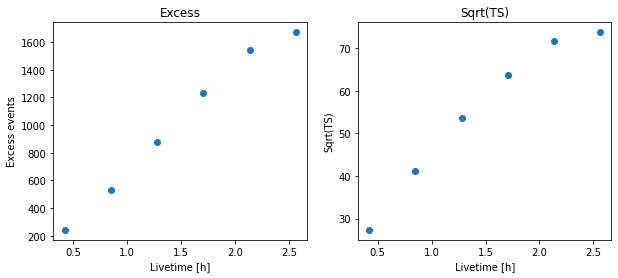

In [8]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

# Spectral model

Get model and parameters from paper

In [10]:
from gammapy.modeling.models import LogParabolaSpectralModel, Models, SkyModel

spectral_model = LogParabolaSpectralModel(
    alpha=2.4,
    amplitude="2.22e-9 cm-2 s-1 TeV-1",
    reference=0.2 * u.TeV,
    beta=1.8,
)
model = SkyModel(spectral_model=spectral_model, name="bllac")

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

In [11]:
print(spectral_model)

LogParabolaSpectralModel

  type      name     value         unit        error   min max frozen is_norm link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ----
spectral amplitude 3.1330e-09 cm-2 s-1 TeV-1 1.066e-10 nan nan  False    True     
spectral reference 2.0000e-01            TeV 0.000e+00 nan nan   True   False     
spectral     alpha 2.5867e+00                1.168e-01 nan nan  False   False     
spectral      beta 4.8417e-01                8.064e-02 nan nan  False   False     


In [12]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 111
	total stat : 201.32

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [13]:
display(result_joint.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str5,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
bllac,spectral,amplitude,3.1330e-09,cm-2 s-1 TeV-1,1.066e-10,nan,nan,False,True,
bllac,spectral,reference,2.0000e-01,TeV,0.000e+00,nan,nan,True,False,
bllac,spectral,alpha,2.5867e+00,,1.168e-01,nan,nan,False,False,
bllac,spectral,beta,4.8417e-01,,8.064e-02,nan,nan,False,False,


# Plot fit results with data

Text(0.5, 1.0, '1ES 1959+650')

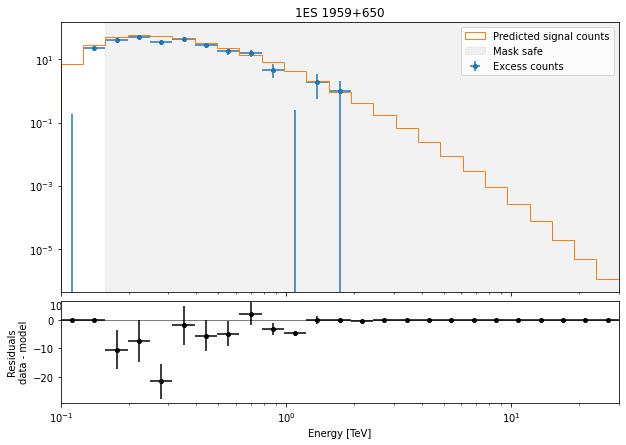

In [15]:
plt.figure(figsize=(10,7))
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_yscale('log')
datasets[0].plot_masks(ax=ax_spectrum)
ax_spectrum.set_title('1ES 1959+650')

In [105]:
e_min, e_max = 0.11, 4
energy_edges = np.geomspace(e_min, e_max, 8) * u.TeV

In [106]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="bllac", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

In [107]:
display(flux_points.to_table(sed_type="dnde", formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[6],float32[6],float64,bool,float64[6],bool,float64[11],float64[11]
0.141,0.100,0.198,7.990e-09,5.743e-10,5.867e-10,5.621e-10,9.188e-09,588.263,24.254,62.27568760116677 .. 0.0,56.858734 .. 0.0,11.930,False,47.0 .. 0.0,True,0.200 .. 5.000,287.785 .. 864.497
0.249,0.198,0.313,1.655e-09,6.812e-11,6.897e-11,6.726e-11,1.794e-09,1939.197,44.036,117.62762991079637 .. 100.33816174576728,110.903275 .. 92.19371,37.236,False,94.0 .. 68.0,True,0.200 .. 5.000,820.596 .. 3260.400
0.393,0.313,0.494,4.547e-10,2.088e-11,2.118e-11,2.057e-11,4.977e-10,1799.363,42.419,86.56627741246083 .. 83.57120738890521,82.969666 .. 80.46959,37.937,False,76.0 .. 46.0,True,0.200 .. 5.000,757.259 .. 2227.400
0.620,0.494,0.779,8.967e-11,6.121e-12,6.255e-12,5.988e-12,1.024e-10,818.488,28.609,38.495808352539946 .. 39.566159334566684,36.752296 .. 37.454197,41.165,False,36.0 .. 17.0,True,0.200 .. 5.000,356.544 .. 1105.335
1.097,0.779,1.545,8.631e-12,9.768e-13,1.012e-12,9.421e-13,1.073e-11,278.789,16.697,13.633566901202322 .. 15.426515465947551,13.032021 .. 14.4599,48.916,False,7.0 .. 7.0,True,0.200 .. 5.000,153.663 .. 493.304
1.941,1.545,2.439,9.693e-13,2.889e-13,3.174e-13,2.618e-13,1.664e-12,45.305,6.731,1.8186546495679337 .. 2.3707142133559502,1.8186548 .. 2.187896,11.283,False,1.0 .. 1.0,True,0.200 .. 5.000,33.383 .. 43.282
3.064,2.439,3.849,8.395e-14,6.703e-14,8.418e-14,6.064e-14,2.891e-13,1.890,1.375,0.27013671909365716 .. 0.41712095934224935,0.2701367 .. 0.34495974,6.913,True,0.0 .. 1.0,True,0.200 .. 5.000,8.219 .. 13.210


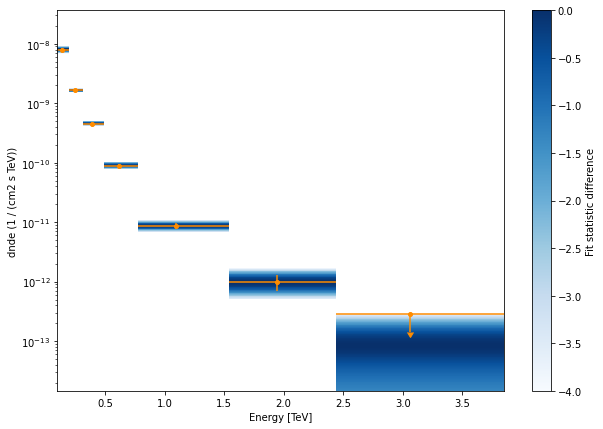

In [108]:
fig, ax = plt.subplots(figsize=(10,7))
flux_points.plot(ax=ax, sed_type="dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="dnde")
ax.set_xscale('linear')

(<AxesSubplot: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <AxesSubplot: xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

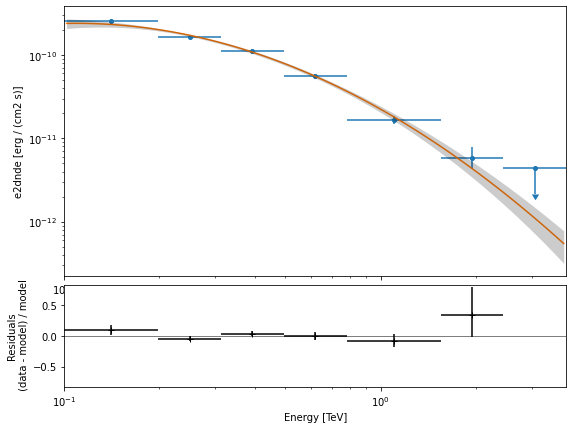

In [109]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model_best_joint)
flux_points_dataset.plot_fit()

In [110]:
t = model_best_joint.parameters.to_table()
display(t)

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,amplitude,3.1330e-09,cm-2 s-1 TeV-1,1.066e-10,nan,nan,False,True,
spectral,reference,2.0000e-01,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,2.5867e+00,,1.168e-01,nan,nan,False,False,
spectral,beta,4.8417e-01,,8.064e-02,nan,nan,False,False,


# Overlay above analysis with fit from paper (VTSCat)

In [111]:
from astropy.table import Table
paper = Table.read('bllac_paper_spectrum.ecsv', format='ascii.ecsv')
print(paper)

e_ref  e_min  e_max      e2dnde      e2dnde_err 
 TeV    TeV    TeV   erg / (cm2 s) erg / (cm2 s)
------ ------ ------ ------------- -------------
0.1567 0.1259 0.1995  1.491028e-10   6.01919e-12
0.2484 0.1995 0.3162  1.285154e-10  4.666097e-12
0.3937 0.3162 0.5012  6.878903e-11  3.625703e-12
0.6239 0.5012 0.7943  3.467475e-11  2.875011e-12
0.9888 0.7943 1.2589   8.41201e-12   1.78579e-12
 1.567 1.2589 1.9953  2.915176e-12  1.510699e-12


/tmp/ipykernel_182256/3353962925.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,5)


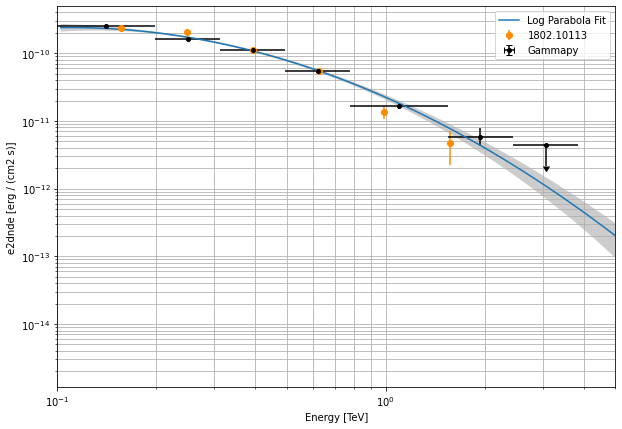

In [112]:
fig, ax = plt.subplots(figsize=(10,7))
plt.errorbar(paper['e_ref'],paper['e2dnde']*1.602,yerr=paper['e2dnde_err']*1.602,color='darkorange',ls='',marker='o',label='1802.10113')
flux_points.plot(ax=ax, sed_type="e2dnde", color="k",label='Gammapy')
energy_bounds = [0.1, 10] * u.TeV
spectral_model.plot(energy_bounds,sed_type='e2dnde',label='Log Parabola Fit')
spectral_model.plot_error(energy_bounds,sed_type='e2dnde',alpha=0.2)
ax.grid(which='minor')
ax.grid(which='major')
ax.set_xlim(0,5)
ax.set_xscale('log')
ax.legend()

In [113]:
gammapy_flux = flux_points.to_table(sed_type='dnde')
display(gammapy_flux)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[6],float32[6],float64,bool,float64[6],bool,float64[11],float64[11]
0.1408079822829465,0.10000000000000002,0.19826887874594568,7.989701474547773e-09,5.743416810830802e-10,5.867119166056226e-10,5.6212504271441e-10,9.188232963831279e-09,588.2626034964537,24.25412549436598,62.27568760116677 .. 0.0,56.858734 .. 0.0,11.929725089435237,False,47.0 .. 0.0,True,0.2 .. 4.999999999999999,287.78527690946703 .. 864.4967923315972
0.24908031183062881,0.19826887874594568,0.31291346445318985,1.6545491378088905e-09,6.811807657341067e-11,6.89728685498739e-11,6.725676790936187e-11,1.7940665903002824e-09,1939.1971191435841,44.03631591247824,117.62762991079637 .. 100.33816174576728,110.903275 .. 92.19371,37.23558860329638,False,94.0 .. 68.0,True,0.2 .. 4.999999999999999,820.5964654197794 .. 3260.4003240990914
0.39310548279174495,0.31291346445318985,0.49384874144349267,4.547256021009175e-10,2.0876292259549497e-11,2.1182568687423314e-11,2.057432811638156e-11,4.977290007778259e-10,1799.3629923391954,42.41889899961096,86.56627741246083 .. 83.57120738890521,82.969666 .. 80.46959,37.9368394357557,False,76.0 .. 46.0,True,0.2 .. 4.999999999999999,757.2593917177137 .. 2227.4002557941494
0.6204100174164326,0.49384874144349267,0.779405833020029,8.966642740117569e-11,6.120920852836042e-12,6.254721604232142e-12,5.98848796310104e-12,1.024455797812898e-10,818.4883078548932,28.609234660418533,38.495808352539946 .. 39.566159334566684,36.752296 .. 37.454197,41.164784064480855,False,36.0 .. 17.0,True,0.2 .. 4.999999999999999,356.5440777567718 .. 1105.334520244211
1.0974656272710936,0.779405833020029,1.5453192060093088,8.630770176362432e-12,9.768318793591896e-13,1.0122529875673893e-12,9.420725277947372e-13,1.0727381851917111e-11,278.78948837018214,16.696990398577288,13.633566901202322 .. 15.426515465947551,13.032021 .. 14.4599,48.91579214795593,False,7.0 .. 7.0,True,0.2 .. 4.999999999999999,153.6632237422974 .. 493.30357547755955
1.941346479312398,1.5453192060093088,2.438865794253216,9.692845880871364e-13,2.889256613757706e-13,3.174361684423062e-13,2.617634303825015e-13,1.6635590145314125e-12,45.304645344276196,6.730872554452074,1.8186546495679337 .. 2.3707142133559502,1.8186548 .. 2.187896,11.283119198381984,False,1.0 .. 1.0,True,0.2 .. 4.999999999999999,33.3828940517158 .. 43.28242522542719
3.0638870628004056,2.438865794253216,3.849085897106582,8.395124543230882e-14,6.70282913457165e-14,8.418402946061758e-14,6.063961958248122e-14,2.8913610226566687e-13,1.8902438835879423,1.3748614052288843,0.27013671909365716 .. 0.41712095934224935,0.2701367 .. 0.34495974,6.912519257662879,True,0.0 .. 1.0,True,0.2 .. 4.999999999999999,8.219026546821254 .. 13.210081904472522


In [114]:
print(spectral_model(gammapy_flux['e_ref']))
print(gammapy_flux['dnde'])
print(gammapy_flux['dnde_err'])

[7.31628106e-09 1.73496044e-09 4.37301660e-10 9.00969683e-11
 9.41860820e-12 7.18533274e-13 7.30982868e-14] 1 / (cm2 s TeV)
         dnde         
   1 / (cm2 s TeV)    
----------------------
 7.989701474547773e-09
1.6545491378088905e-09
 4.547256021009175e-10
 8.966642740117569e-11
 8.630770176362432e-12
 9.692845880871364e-13
 8.395124543230882e-14
       dnde_err       
   1 / (cm2 s TeV)    
----------------------
 5.743416810830802e-10
 6.811807657341067e-11
2.0876292259549497e-11
 6.120920852836042e-12
 9.768318793591896e-13
 2.889256613757706e-13
  6.70282913457165e-14


In [115]:
def reduced_chi_squared(y, y_model,sigma,n_params):
    chi_squared = np.sum(((y - y_model) / sigma) ** 2)
    d_o_f = len(y) - n_params
    return chi_squared, d_o_f

chisq,dof = reduced_chi_squared(gammapy_flux['dnde'],spectral_model(gammapy_flux['e_ref']),gammapy_flux['dnde_err'],3)
print(chisq,dof)

4.89973964598958 4
